In [24]:
from openai import OpenAI
import fitz
import os
import json
import pandas as pd
from pydantic import (BaseModel,
                      Field,
                      )
from enum import Enum
from tqdm import tqdm
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             f1_score,
                             precision_score,
                             recall_score,
                             roc_auc_score)

In [2]:
client = OpenAI(api_key='any-key', base_url='http://mn-dgx01.x5.ru:8000/v1')

## Извлечение признаков из текста резюме с помощью LLM

Более подробно посмотрел на резюме ребят, которые успешно справлялись с первым этапом собеседования. Решил извлекать следующие признаки:

1. Опыт работы в месяцах
2. Название учебного заведения. Взял топ-15 универов по одной из первых [ссылок](https://raex-rr.com/education/russian_universities/top-100_universities/2024/) в браузере. Другие универы просил пометить как `другое`.
3. Специализация. Извлекал одну из следующих специализаций: `программирование`, `математика`, `физика`, `экономика` или `другое`.
4. 1, если есть опыт работы дата-аналитиком, 0 иначе.
5. 1, если в резюме есть python, 0 иначе.
6. 1, если в резюме есть pandas, 0 иначе.
7. 1, если в резюме есть sql, 0 иначе.
8. 1, если в резюме есть математическая статистика, 0 иначе.
9. 1, если в резюме есть ml, machine learning или машинное обучение, 0 иначе.

In [ ]:
class UniType(str, Enum):
    msu = 'Московский государственный университет имени М.В. Ломоносова'
    mstu = 'Московский государственный технический университет имени Н.Э. Баумана'
    mipt = 'Московский физико-технический институт'
    spbsu = 'Санкт-Петербургский государственный университет'
    mephi = 'Национальный исследовательский ядерный университет «МИФИ»'
    hse = 'Национальный исследовательский университет "Высшая школа экономики"'
    spbpu = 'Санкт-Петербургский политехнический университет Петра Великого'
    tpu = 'Национальный исследовательский Томский политехнический университет'
    urfu = 'Уральский федеральный университет имени первого Президента России Б.Н. Ельцина'
    fu = 'Финансовый университет при Правительстве РФ'
    itmo = 'Университет ИТМО'
    nsu = 'Новосибирский национальный исследовательский государственный университет'
    misis = 'Университет МИСИС'
    other = 'Другое'

class EducationType(str, Enum):
    it = 'программирование'
    math = 'математика'
    physics = 'физика'
    economics = 'экономика'
    other = 'другое'

class BinaryFeature(int, Enum):
    one = 1
    zero = 0

class FeaturesSchema(BaseModel):
    work_experience: float = Field(..., description="Опыт работы в месяцах.")
    university: UniType = Field(..., description="""Одно из следующих учебных заведений:
                            'Московский государственный университет имени М.В. Ломоносова',
                            'Московский государственный технический университет имени Н.Э. Баумана',
                            'Московский физико-технический институт',
                            'Санкт-Петербургский государственный университет',
                            'Национальный исследовательский ядерный университет «МИФИ»',
                            'Национальный исследовательский университет "Высшая школа экономики"',
                            'Санкт-Петербургский политехнический университет Петра Великого',
                            'Национальный исследовательский Томский политехнический университет',
                            'Уральский федеральный университет имени первого Президента России Б.Н. Ельцина',
                            'Финансовый университет при Правительстве РФ',
                            'Университет ИТМО',
                            'Новосибирский национальный исследовательский государственный университет',
                            'Университет МИСИС'
                            'Другое'.
                            """)
    education_type: EducationType = Field(..., description="Одну из следующих специализаций: программирование, математика, физика, экономика или другое.")
    python_knowledge: BinaryFeature = Field(..., description="1, если в резюме есть python, 0 иначе.")
    pandas_knowledge: BinaryFeature = Field(..., description="1, если в резюме есть pandas, 0 иначе.")
    sql_knowledge: BinaryFeature = Field(..., description="1, если в резюме есть sql, 0 иначе.")
    math_stat_knowledge: BinaryFeature = Field(..., description="1, если в резюме есть математическая статистика, 0 иначе.")
    ml_knowledge: BinaryFeature = Field(..., description="1, если в резюме есть ml, machine learning или машинное обучение, 0 иначе.")

In [4]:
def extract_features(resume_text: str, client: OpenAI) -> dict:
    messages = [
        {"role": "system", "content": "Ты интеллектуальный ассистент для извлечения необходимой информации из резюме кандидата."},
        {'role': 'user', 'content': f"""
            Извлеки следующую информацию из резюме:

            1. Опыт работы в месяцах.
            2. Одно из следующих учебных заведений: 'Московский государственный университет имени М.В. Ломоносова', 
            'Московский государственный технический университет имени Н.Э. Баумана', 'Московский физико-технический институт',
            'Санкт-Петербургский государственный университет', 'Национальный исследовательский ядерный университет «МИФИ»',
            'Национальный исследовательский университет "Высшая школа экономики"', 'Санкт-Петербургский политехнический университет Петра Великого',
            'Национальный исследовательский Томский политехнический университет', 'Уральский федеральный университет имени первого Президента России Б.Н. Ельцина',
            'Финансовый университет при Правительстве РФ', 'Университет ИТМО', 'Новосибирский национальный исследовательский государственный университет',
            'Университет МИСИС' или 'другое'.
            3. Одну из следующих специализаций: программирование, математика, физика, экономика или другое.
            4. 1, если есть опыт работы дата-аналитиком, 0 иначе.
            5. 1, если в резюме есть python, 0 иначе.
            6. 1, если в резюме есть pandas, 0 иначе.
            7. 1, если в резюме есть sql, 0 иначе.
            8. 1, если в резюме есть математическая статистика, 0 иначе.
            9. 1, если в резюме есть ml, machine learning или машинное обучение, 0 иначе.

            Резюме:
            ```{resume_text}```

            В ответе предоставь JSON следующего формата:
            Опыт: <опыт работы>
            Образование: <название учебного заведения>
            Специализация: <программирование или математика или физика или экономика или другое>
            Олимпиады: <название олимпиады или пустая строка>
            Дата-аналитик: <0 или 1>
            Python: <0 или 1>
            Pandas: <0 или 1>
            SQL: <0 или 1>
            Математическая статистика: <0 или 1>
            ML/Machine Learning/машинное обучение: <0 или 1>
            """}
        ]

    try:
        response = client.chat.completions.create(
            model="x5-airun-medium",
            messages=messages,
            max_tokens=1024,
            temperature=0,
            top_p=0.2,
            n=1,
            extra_body={"guided_json": FeaturesSchema.model_json_schema()},
            stop=None,
        )

        answer = response.choices[0].message.content
        print(answer)

    except Exception as e:
        print(f"Ошибка при обращении к API: {e}")

    return json.loads(answer)

def extract_text_from_pdf(pdf_path: str) -> str:
    extracted_text = ""
    with fitz.open(pdf_path) as pdf:
        for page_num in range(pdf.page_count):
            page = pdf[page_num]
            extracted_text += page.get_text()
    return extracted_text

In [5]:
preprocessed_data_dir_path = "../data/preprocessed/combined_data_preprocessed/interns_preprocessed"
waves = ["2023_1", "2023_2", "2024_1", "2024_2"]

In [6]:
features_df = pd.DataFrame()
interns_df = pd.read_csv("../data/preprocessed/combined_data_preprocessed/interns_preprocessed/interns_preprocessed.csv")

In [ ]:
for wave_dir in tqdm(waves, desc="1st loop"):
# for wave_dir in waves:
    for resume_path in tqdm(os.listdir(os.path.join(preprocessed_data_dir_path, wave_dir)), desc="2nd loop"):
        resume_text = extract_text_from_pdf(os.path.join(preprocessed_data_dir_path, wave_dir, resume_path))

        result = extract_features(resume_text, client)

        result["Резюме"] = os.path.join("interns_preprocessed", wave_dir, resume_path)
        hire_status = interns_df[interns_df["Резюме"] == os.path.join("interns_preprocessed", wave_dir, resume_path)]["Hire status"].iloc[0]
        result["Hire status"] = hire_status


        features_df = pd.concat([features_df, pd.DataFrame([result])], ignore_index=True)

        print(resume_path, end="\n\n")
        # print(result)
        print("\n" + "-" * 30)

In [10]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   work_experience      311 non-null    int64 
 1   university           311 non-null    object
 2   education_type       311 non-null    object
 3   python_knowledge     311 non-null    int64 
 4   pandas_knowledge     311 non-null    int64 
 5   sql_knowledge        311 non-null    int64 
 6   math_stat_knowledge  311 non-null    int64 
 7   ml_knowledge         311 non-null    int64 
 8   Резюме               311 non-null    object
 9   Hire status          311 non-null    int64 
dtypes: int64(7), object(3)
memory usage: 24.4+ KB


In [ ]:
features_df

In [ ]:
features_df["work_experience"] = features_df["work_experience"].astype(float)
features_df

In [52]:
str_form_features_df = pd.DataFrame()
str_form_features_df["Резюме"] = None
str_form_features_df["text"] = None
str_form_features_df["response"] = None
str_form_features_df

,Резюме,text,response


In [ ]:
for i, row in features_df.iterrows():
    response = str(dict(row))
    resume_path = row["Резюме"]
    text = extract_text_from_pdf("../data/preprocessed/combined_data_preprocessed/" + resume_path)
    text = text.replace("\n", " ")
    str_form_features_df = pd.concat([str_form_features_df,
                                      pd.DataFrame({"Резюме": [resume_path],
                                                    "text": [text],
                                                    "response": [response]})],
                                                    ignore_index=True)

str_form_features_df

In [ ]:
str_form_features_df = pd.merge(interns_df,
                                str_form_features_df,
                                on="Резюме")
str_form_features_df

In [55]:
str_form_features_df.to_csv("../data/extracted_features/features/x5_llm_features_interns_v2.csv", index=False)

In [14]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   work_experience      311 non-null    float64
 1   university           311 non-null    object 
 2   education_type       311 non-null    object 
 3   python_knowledge     311 non-null    int64  
 4   pandas_knowledge     311 non-null    int64  
 5   sql_knowledge        311 non-null    int64  
 6   math_stat_knowledge  311 non-null    int64  
 7   ml_knowledge         311 non-null    int64  
 8   Резюме               311 non-null    object 
 9   Hire status          311 non-null    int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 24.4+ KB


## Boosting

Почти все признаки категориальные, поэтому в качестве модели используем `CatBoost`

In [ ]:
data = pd.read_csv("../data/extracted_features/features/x5_llm_features_interns_v2.csv")

X = data.drop(['Резюме', 'Hire status'], axis=1)
y = data['Hire status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features_indices = [i for i in range(1, 8)]

train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features_indices)
test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_features_indices)

# Параметры модели
model_params = {
    'iterations': 1000,
    'learning_rate': 0.01,
    'depth': 6,
    'loss_function': 'Logloss',
    'eval_metric': 'F1',
    'random_seed': 42,
    'use_best_model': True
}

cv_data = cv(
    pool=train_pool,
    params=model_params,
    fold_count=5,
    plot=True,
    verbose=200
)

model = CatBoostClassifier(**model_params)
model.fit(train_pool, eval_set=test_pool, verbose=200)

y_pred = model.predict(X_test)

# model.save_model('catboost_model.cbm')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 0.2857143	test: 0.3636364	best: 0.3636364 (0)	total: 16.7ms	remaining: 16.7s
200:	learn: 0.8279570	test: 0.4615385	best: 0.5666667 (1)	total: 5.53s	remaining: 22s
400:	learn: 0.8663102	test: 0.4313725	best: 0.5666667 (1)	total: 11.3s	remaining: 16.9s
600:	learn: 0.9139785	test: 0.4230769	best: 0.5666667 (1)	total: 16.5s	remaining: 11s
800:	learn: 0.9468085	test: 0.4313725	best: 0.5666667 (1)	total: 21.7s	remaining: 5.38s
999:	learn: 0.9791667	test: 0.4528302	best: 0.5666667 (1)	total: 27.3s	remaining: 0us

bestTest = 0.5666666667
bestIteration = 1

Training on fold [1/5]
0:	learn: 0.6718750	test: 0.5970149	best: 0.5970149 (0)	total: 17.6ms	remaining: 17.6s
200:	learn: 0.8176796	test: 0.4400000	best: 0.5970149 (0)	total: 4.78s	remaining: 19s
400:	learn: 0.8756757	test: 0.4081633	best: 0.5970149 (0)	total: 10.1s	remaining: 15s
600:	learn: 0.9157895	test: 0.4081633	best: 0.5970149 (0)	total: 15.3s	remaining: 10.2s
800:	learn: 0.9637306	test: 0.4255319	best

In [31]:
test_f1_mean = cv_data["test-F1-mean"].max()
print(f'F1 score: {test_f1_mean:.4f}')

F1 score: 0.4882


In [27]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

f1 = f1_score(y_test, y_pred)
print(f'F1 score: {f1:.4f}')

precision = precision_score(y_test, y_pred)
print(f'Precision score: {precision:.4f}')

recall = recall_score(y_test, y_pred)
print(f'Recall score: {recall:.4f}')

roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc:.4f}')

Accuracy: 0.5714
F1 score: 0.5970
Precision score: 0.6250
Recall score: 0.5714
ROC AUC: 0.5714


In [28]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,work_experience,18.376111
1,education_type,17.553405
2,university,16.541098
3,math_stat_knowledge,13.998972
4,sql_knowledge,13.871916
5,ml_knowledge,13.502128
6,pandas_knowledge,6.156370
7,python_knowledge,0.000000


In [18]:
y_pred, y_test.to_numpy()

(array([1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
        0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0],
       dtype=int64),
 array([1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0],
       dtype=int64))

In [22]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def vizualize(df, norm=False):
    scaler = StandardScaler()
    
    X = pd.get_dummies(df.drop(columns=['Резюме', 'Hire status']), drop_first=True)
    if norm:
        X = scaler.fit_transform(X)
    y = df['Hire status']
    
    for curmetric in ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'euclidean', 'hamming', 'minkowski', 'sqeuclidean']:
        tsne = TSNE(random_state = 42, n_iter = 1000, metric = curmetric)
        embeddings2d = tsne.fit_transform(X)
        embeddingsdf = pd.DataFrame()
        embeddingsdf['label'] = y
        embeddingsdf['x'] = embeddings2d[:,0]
        embeddingsdf['y'] = embeddings2d[:,1]
        fig, ax = plt.subplots(figsize=(5, 3))
    
        for label in embeddingsdf['label'].unique():
            subset = embeddingsdf[embeddingsdf['label'] == label]
            ax.scatter(subset['x'], subset['y'], alpha=0.7, label=label)
        
        plt.title(f'{curmetric}')
        plt.legend()  # Show the legend with labels
        plt.show()

c:\Users\iliya.khrustalev\Documents\GitHub\resume_screener\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


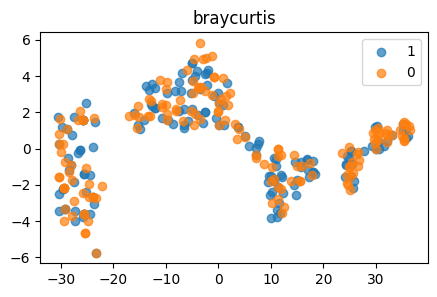

c:\Users\iliya.khrustalev\Documents\GitHub\resume_screener\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


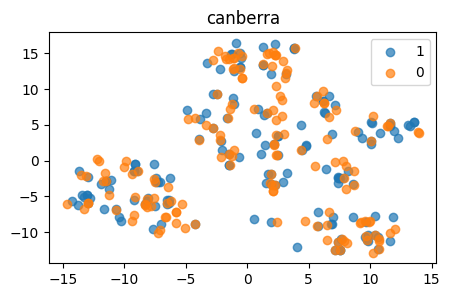

c:\Users\iliya.khrustalev\Documents\GitHub\resume_screener\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


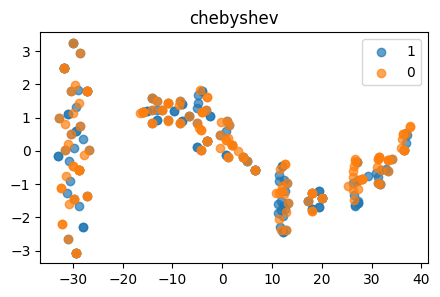

c:\Users\iliya.khrustalev\Documents\GitHub\resume_screener\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


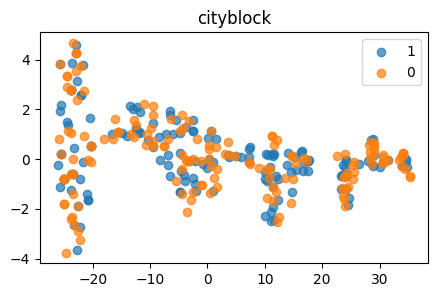

c:\Users\iliya.khrustalev\Documents\GitHub\resume_screener\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


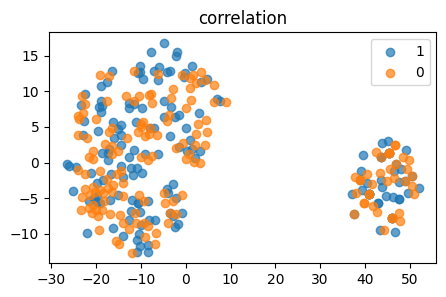

c:\Users\iliya.khrustalev\Documents\GitHub\resume_screener\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


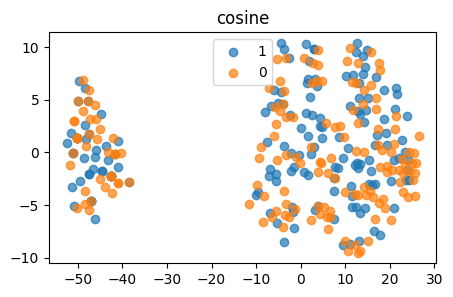

c:\Users\iliya.khrustalev\Documents\GitHub\resume_screener\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


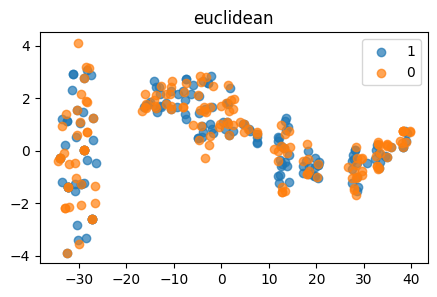

c:\Users\iliya.khrustalev\Documents\GitHub\resume_screener\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


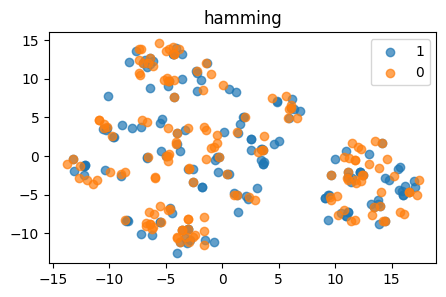

c:\Users\iliya.khrustalev\Documents\GitHub\resume_screener\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


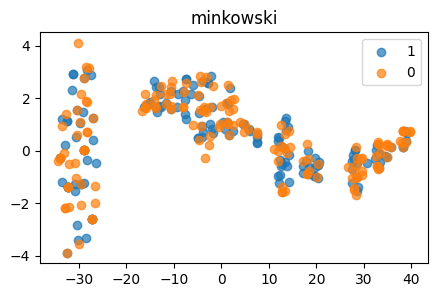

c:\Users\iliya.khrustalev\Documents\GitHub\resume_screener\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


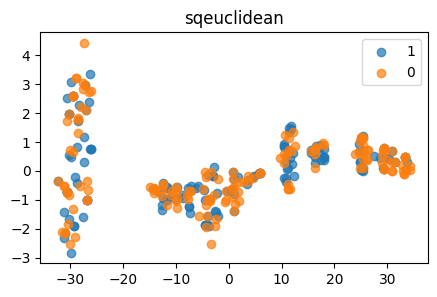

In [23]:
vizualize(features_df)